In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load the full data
data = pd.read_parquet(
    "/content/drive/MyDrive/Colab Notebooks/5km_resolution_with_missing_data_handled_2022_to_2025.parquet",
    engine='pyarrow'
)

print("Shape:", data.shape)
print("Columns:", data.columns.tolist())
print(data.head())


Shape: (14146902, 13)
Columns: ['lat_5km', 'lon_5km', 'KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM', 'time', 'flags', 'date']
   lat_5km  lon_5km     KD490        ZSD  RRS490  RRS443       CHL  MICRO  \
0    49.15   -10.75  0.035727  26.936846    -2.0    -2.0  0.124980   -2.0   
1    49.15   -10.70  0.035727  26.936848    -2.0    -2.0  0.124980   -2.0   
2    49.15   -10.65  0.035787  26.878199    -2.0    -2.0  0.125559   -2.0   
3    49.15   -10.60  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   
4    49.15   -10.55  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   

   BBP  CDM       time  flags        date  
0 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
1 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
2 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
3 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
4 -2.0 -2.0 2025-01-01    0.0  2025-01-01  


## Data Preprocessing: Removing Land Data and missing values

In [3]:
# Data Preprocessing: Remove Land Data

# Define parameter columns that contain -1.0 for land data
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

# Filter out rows where "flags" column is 1.0 (land data)
data = data[data["flags"] != 1.0].copy()

# Filter out rows where any parameter column contains -1.0 (land data)
# Use .any(axis=1) to check if -1.0 exists in any of the specified columns for a given row
land_data_in_params = (data[parameter_columns] == -1.0).any(axis=1)
data = data[~land_data_in_params].copy()

print(f"Shape after removing land data: {data.shape}")



Shape after removing land data: (10987584, 13)


In [4]:
# Missing Data Handling (-2.0)
import numpy as np

# Replace -2.0 values in parameter columns with NaN
for col in parameter_columns:
    data[col] = data[col].replace(-2.0, np.nan)

print("Missing data (-2.0) replaced with NaN.")
print("NaN counts per parameter column after replacement:")
print(data[parameter_columns].isnull().sum())

Missing data (-2.0) replaced with NaN.
NaN counts per parameter column after replacement:
KD490           0
ZSD             0
RRS490    1443936
RRS443    1443936
CHL             0
MICRO     1871136
BBP       1666080
CDM       1666080
dtype: int64


In [5]:
# Remove Rows with Any NaN Values
# Get the initial shape before dropping NaNs
initial_rows = data.shape[0]

data.dropna(inplace=True)

# Get the shape after dropping NaNs
final_rows = data.shape[0]

print(f"\nRemoved {initial_rows - final_rows} rows containing NaN values.")
print(f"New Data Shape after dropping NaNs: {data.shape}")


Removed 1871136 rows containing NaN values.
New Data Shape after dropping NaNs: (9116448, 13)


In [6]:
# Convert to datetime if needed
data['date'] = pd.to_datetime(data['date'])

# Unique sorted dates
unique_dates = pd.Series(data['date'].unique()).sort_values()
print(f"\nNumber of unique dates: {len(unique_dates)}")
print(f"Date range: {unique_dates.min().date()} to {unique_dates.max().date()}")

# Full expected date range (daily)
expected_dates = pd.date_range(start=unique_dates.min(), end=unique_dates.max(), freq='D')

# Find missing dates
missing_dates = set(expected_dates) - set(unique_dates)
if missing_dates:
    print(f"\nMissing dates: {len(missing_dates)}")
    print("Example missing dates:", sorted(missing_dates)[:10])
else:
    print("\n All dates are continuous.")



Number of unique dates: 1067
Date range: 2022-01-27 to 2025-07-21

Missing dates: 205
Example missing dates: [Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-22 00:00:00'), Timestamp('2022-11-23 00:00:00'), Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-25 00:00:00'), Timestamp('2022-11-26 00:00:00'), Timestamp('2022-11-27 00:00:00'), Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-29 00:00:00'), Timestamp('2022-11-30 00:00:00')]


In [7]:
import numpy as np

# Ensure date is datetime
data['date'] = pd.to_datetime(data['date'])

# Define specific date ranges for train, validation, and test sets
train_start = pd.to_datetime('2022-01-27')
train_end = pd.to_datetime('2023-11-17')
val_start = pd.to_datetime('2024-01-26')
val_end = pd.to_datetime('2024-07-31')
test_start = pd.to_datetime('2024-08-01')
test_end = pd.to_datetime('2025-07-21')

# Get unique dates in the dataset
unique_dates = sorted(data['date'].unique())

# Filter dates based on the specified ranges
train_dates = [date for date in unique_dates if train_start <= date <= train_end]
val_dates = [date for date in unique_dates if val_start <= date <= val_end]
test_dates = [date for date in unique_dates if test_start <= date <= test_end]

print(f"Train: {len(train_dates)} days")
print(f"Val: {len(val_dates)} days")
print(f"Test: {len(test_dates)} days")
print(f"Total days: {len(train_dates) + len(val_dates) + len(test_dates)}")

if train_dates:
    print(f"Train: {train_dates[0].date()} → {train_dates[-1].date()}")
if val_dates:
    print(f"Val:   {val_dates[0].date()} → {val_dates[-1].date()}")
if test_dates:
    print(f"Test:  {test_dates[0].date()} → {test_dates[-1].date()}")


Train: 593 days
Val: 188 days
Test: 286 days
Total days: 1067
Train: 2022-01-27 → 2023-11-17
Val:   2024-01-26 → 2024-07-31
Test:  2024-08-01 → 2025-07-21


In [8]:
# Create and Save Tensors for Train, Validation, and Test Sets
import numpy as np

# Define feature columns for tensor creation (excluding lat/lon for the 4D tensor)
feature_columns_4d = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

# Get unique latitudes and longitudes to determine spatial dimensions
unique_lats = sorted(data["lat_5km"].unique())
unique_lons = sorted(data["lon_5km"].unique())

print(f"Number of unique latitudes: {len(unique_lats)}")
print(f"Number of unique longitudes: {len(unique_lons)}")

# Function to reshape data into 4D tensor
def reshape_to_4d(df, dates, lats, lons, features):
    num_dates = len(dates)
    num_features = len(features)
    num_lats = len(lats)
    num_lons = len(lons)

    # Initialize an empty tensor with NaNs
    tensor = np.full((num_dates, num_features, num_lats, num_lons), np.nan, dtype=np.float32)

    for i, date in enumerate(dates):
        daily_data = df[df["date"] == date]
        for _, row in daily_data.iterrows():
            lat_idx = lats.index(row["lat_5km"])
            lon_idx = lons.index(row["lon_5km"])
            for j, feature in enumerate(features):
                tensor[i, j, lat_idx, lon_idx] = row[feature]
    return tensor

# Create 4D tensors for each split
train_tensor_4d = reshape_to_4d(data, train_dates, unique_lats, unique_lons, feature_columns_4d)
val_tensor_4d = reshape_to_4d(data, val_dates, unique_lats, unique_lons, feature_columns_4d)
test_tensor_4d = reshape_to_4d(data, test_dates, unique_lats, unique_lons, feature_columns_4d)

# Save 4D tensors as .npy files
np.save("train_tensor_4d_new_split.npy", train_tensor_4d)
np.save("val_tensor_4d_new_split.npy", val_tensor_4d)
np.save("test_tensor_4d_new_split.npy", test_tensor_4d)

print(f"Train 4D tensor shape: {train_tensor_4d.shape}")
print(f"Validation 4D tensor shape: {val_tensor_4d.shape}")
print(f"Test 4D tensor shape: {test_tensor_4d.shape}")
print("\n4D Tensors saved successfully!")
print("Files created:")
print("- train_tensor_4d_new_split.npy")
print("- val_tensor_4d_new_split.npy")
print("- test_tensor_4d_new_split.npy")

# Display feature column mapping for 4D tensor
print("\nFeature column mapping (8 features for 4D tensor):")
for i, col in enumerate(feature_columns_4d):
    print(f"Dimension {i}: {col}")

# Display tensor dimensions explanation
print("\nTensor dimensions explanation:")
print("Dimension 0: Time (number of dates)")
print("Dimension 1: Features (8 oceanographic parameters)")
print("Dimension 2: Latitude (spatial dimension)")
print("Dimension 3: Longitude (spatial dimension)")

Number of unique latitudes: 63
Number of unique longitudes: 173
Train 4D tensor shape: (593, 8, 63, 173)
Validation 4D tensor shape: (188, 8, 63, 173)
Test 4D tensor shape: (286, 8, 63, 173)

4D Tensors saved successfully!
Files created:
- train_tensor_4d_new_split.npy
- val_tensor_4d_new_split.npy
- test_tensor_4d_new_split.npy

Feature column mapping (8 features for 4D tensor):
Dimension 0: KD490
Dimension 1: ZSD
Dimension 2: RRS490
Dimension 3: RRS443
Dimension 4: CHL
Dimension 5: MICRO
Dimension 6: BBP
Dimension 7: CDM

Tensor dimensions explanation:
Dimension 0: Time (number of dates)
Dimension 1: Features (8 oceanographic parameters)
Dimension 2: Latitude (spatial dimension)
Dimension 3: Longitude (spatial dimension)


In [9]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 11.8 MB/s eta 0:00:00


### Moving Average

In [10]:
# Baseline Model: Moving Average on Validation Set
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def symmetric_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denominator == 0, 0, np.abs(y_pred - y_true) / denominator)) * 100

# splits already defined: train_dates, val_dates
# data contains: date, lat_5km, lon_5km, and variables
variables = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]
window_size = 7

results = {}

for var in variables:
    print(f"\nPer-grid Moving Average baseline for {var} (window={window_size})")

    # Build per-grid rolling mean (no leakage: closed='left')
    df_var = data[["date", "lat_5km", "lon_5km", var]].dropna().copy()
    df_var.sort_values(by=["lat_5km", "lon_5km", "date"], inplace=True)

    df_var[f"{var}_ma"] = (
        df_var
        .groupby(["lat_5km", "lon_5km"])[var]
        .transform(lambda x: x.rolling(window=window_size, closed="left", min_periods=1).mean())
    )

    # Select validation period and align actual vs predicted
    val_actual = df_var[df_var["date"].isin(val_dates)][["date", "lat_5km", "lon_5km", var]]
    val_pred   = df_var[df_var["date"].isin(val_dates)][["date", "lat_5km", "lon_5km", f"{var}_ma"]]

    merged = (
        pd.merge(val_actual, val_pred, on=["date", "lat_5km", "lon_5km"], how="inner")
          .dropna()
          .rename(columns={var: "actual", f"{var}_ma": "predicted"})
    )

    if merged.empty:
        print("  Not enough data for evaluation.")
        continue

    # --- Global (micro) metrics over all (date, lat, lon) rows ---
    err = merged["predicted"].to_numpy() - merged["actual"].to_numpy()
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    smape = float(symmetric_mape(merged["actual"], merged["predicted"]))

    results[var] = {"SMAPE (%)": smape, "RMSE": rmse, "MAE": mae}
    print(f"  SMAPE: {smape:.3f}% | RMSE: {rmse:.6f} | MAE: {mae:.6f}")

# Tidy table (variables as rows)
results_df = pd.DataFrame(results).T[["SMAPE (%)", "RMSE", "MAE"]]



Per-grid Moving Average baseline for KD490 (window=7)
  SMAPE: 13.211% | RMSE: 0.030110 | MAE: 0.014399

Per-grid Moving Average baseline for ZSD (window=7)
  SMAPE: 15.102% | RMSE: 2.098349 | MAE: 1.466567

Per-grid Moving Average baseline for RRS490 (window=7)
  SMAPE: 21.670% | RMSE: 0.001915 | MAE: 0.001233

Per-grid Moving Average baseline for RRS443 (window=7)
  SMAPE: 25.769% | RMSE: 0.001834 | MAE: 0.001263

Per-grid Moving Average baseline for CHL (window=7)
  SMAPE: 24.038% | RMSE: 0.964588 | MAE: 0.339840

Per-grid Moving Average baseline for MICRO (window=7)
  SMAPE: 65.144% | RMSE: 4.457565 | MAE: 1.420909

Per-grid Moving Average baseline for BBP (window=7)
  SMAPE: 31.040% | RMSE: 0.005577 | MAE: 0.002583

Per-grid Moving Average baseline for CDM (window=7)
  SMAPE: 27.786% | RMSE: 0.089994 | MAE: 0.022183


In [27]:
print("\nSummary of Evaluation Metrics:")
print(results_df.round(4))


Summary of Evaluation Metrics:
        SMAPE (%)    RMSE     MAE
KD490     13.2114  0.0301  0.0144
ZSD       15.1017  2.0983  1.4666
RRS490    21.6704  0.0019  0.0012
RRS443    25.7689  0.0018  0.0013
CHL       24.0378  0.9646  0.3398
MICRO     65.1437  4.4576  1.4209
BBP       31.0404  0.0056  0.0026
CDM       27.7860  0.0900  0.0222


In [13]:
# Final summary
print("\nSummary of Evaluation Metrics:")
mse_df = pd.DataFrame(results).T.round(4)
print(mse_df)


Summary of Evaluation Metrics:
        SMAPE (%)    RMSE     MAE
KD490     13.2114  0.0301  0.0144
ZSD       15.1017  2.0983  1.4666
RRS490    21.6704  0.0019  0.0012
RRS443    25.7688  0.0018  0.0013
CHL       24.0378  0.9646  0.3398
MICRO     65.1437  4.4576  1.4209
BBP       31.0404  0.0056  0.0026
CDM       27.7860  0.0900  0.0222


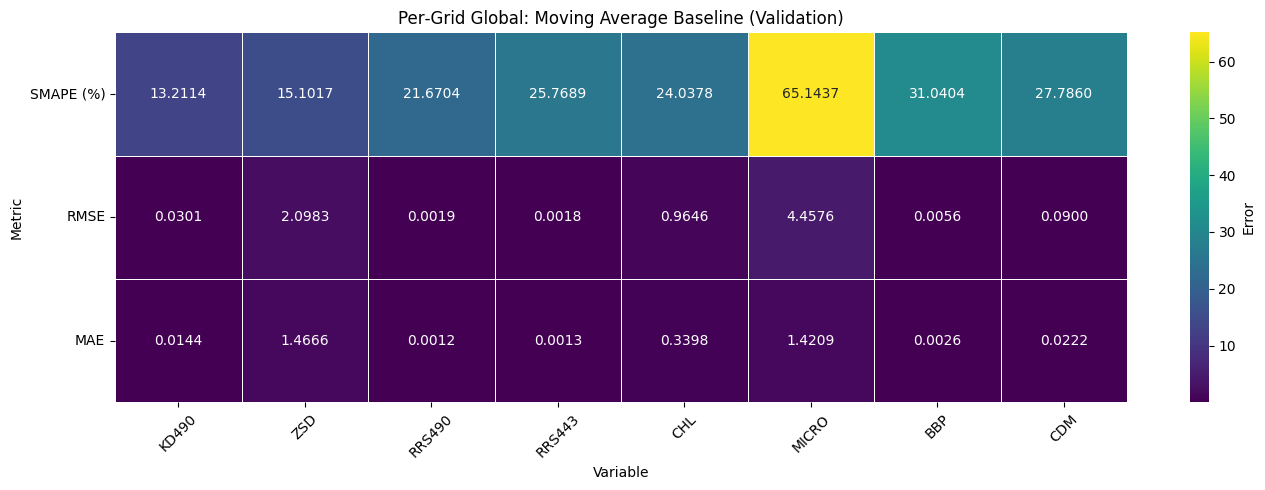

In [33]:
# Build DF from results (variables as rows)
metrics_df = pd.DataFrame(results).T

wanted = ["SMAPE (%)", "RMSE", "MAE"]
for col in wanted:
    if col not in metrics_df.columns:
        metrics_df[col] = np.nan

heatmap_data = metrics_df[wanted].T  # metrics as rows, variables as cols

# Plot heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".4f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Error"}
)
plt.title("Per‑Grid Global: Moving Average Baseline (Validation)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

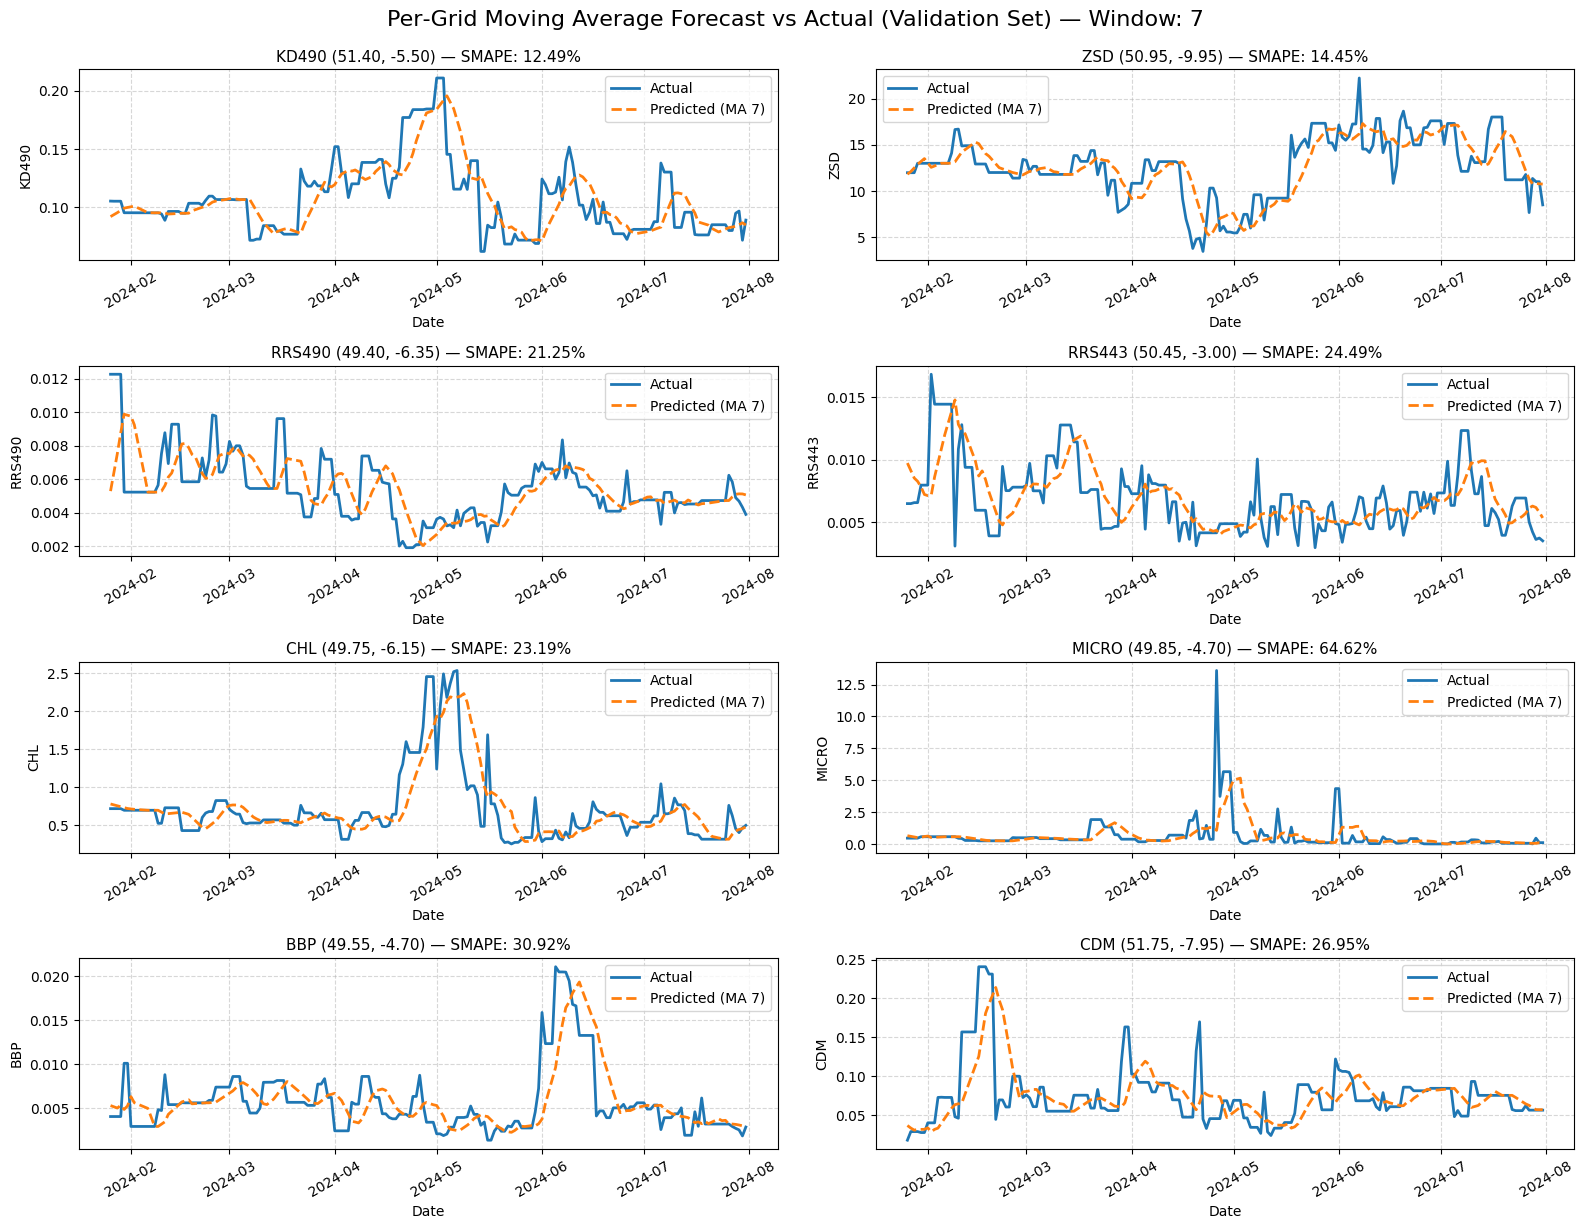

In [29]:
window_size = 7
min_points = 15

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # 1) Build per-grid moving average (no leakage: closed='left')
    df_var = data[["date", "lat_5km", "lon_5km", var]].dropna().copy()
    df_var.sort_values(by=["lat_5km", "lon_5km", "date"], inplace=True)
    df_var[f"{var}_ma"] = (
        df_var.groupby(["lat_5km", "lon_5km"])[var]
              .transform(lambda x: x.rolling(window=window_size, closed="left", min_periods=1).mean())
    )

    # 2) Validation slice
    val_df = df_var[df_var["date"].isin(val_dates)].copy()
    val_df = val_df.dropna(subset=[var, f"{var}_ma"])

    ax = axes[i]

    if val_df.empty:
        ax.set_title(f"{var} — No validation data")
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.axis("off")
        continue

    # 3) Compute SMAPE per grid and select the median-SMAPE grid (more representative)
    smape_rows = []
    for (lat, lon), g in val_df.groupby(["lat_5km", "lon_5km"]):
        if len(g) < min_points:
            continue
        s = symmetric_mape(g[var].to_numpy(), g[f"{var}_ma"].to_numpy())
        smape_rows.append((lat, lon, s))

    if not smape_rows:
        ax.set_title(f"{var} — No grid with ≥{min_points} pts")
        ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax.transAxes)
        ax.axis("off")
        continue

    # Pick grid closest to median SMAPE
    smapes = np.array([r[2] for r in smape_rows])
    med = np.median(smapes)
    lat_sel, lon_sel, smape_sel = min(smape_rows, key=lambda r: abs(r[2] - med))

    # 4) Extract that grid’s series and plot
    gsel = val_df[(val_df["lat_5km"] == lat_sel) & (val_df["lon_5km"] == lon_sel)].copy()
    gsel.sort_values("date", inplace=True)

    ax.plot(gsel["date"], gsel[var], label="Actual", linewidth=2.0)
    ax.plot(gsel["date"], gsel[f"{var}_ma"], label=f"Predicted (MA {window_size})",
            linestyle="--", linewidth=2.0)

    ax.set_title(f"{var} ({lat_sel:.2f}, {lon_sel:.2f}) — SMAPE: {smape_sel:.2f}%", fontsize=11)
    ax.set_xlabel("Date"); ax.set_ylabel(var)
    ax.tick_params(axis="x", rotation=30)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.suptitle(f"Per‑Grid Moving Average Forecast vs Actual (Validation Set) — Window: {window_size}",
             fontsize=16, y=1.02)
plt.show()

## Spacial Averaging Moving Average

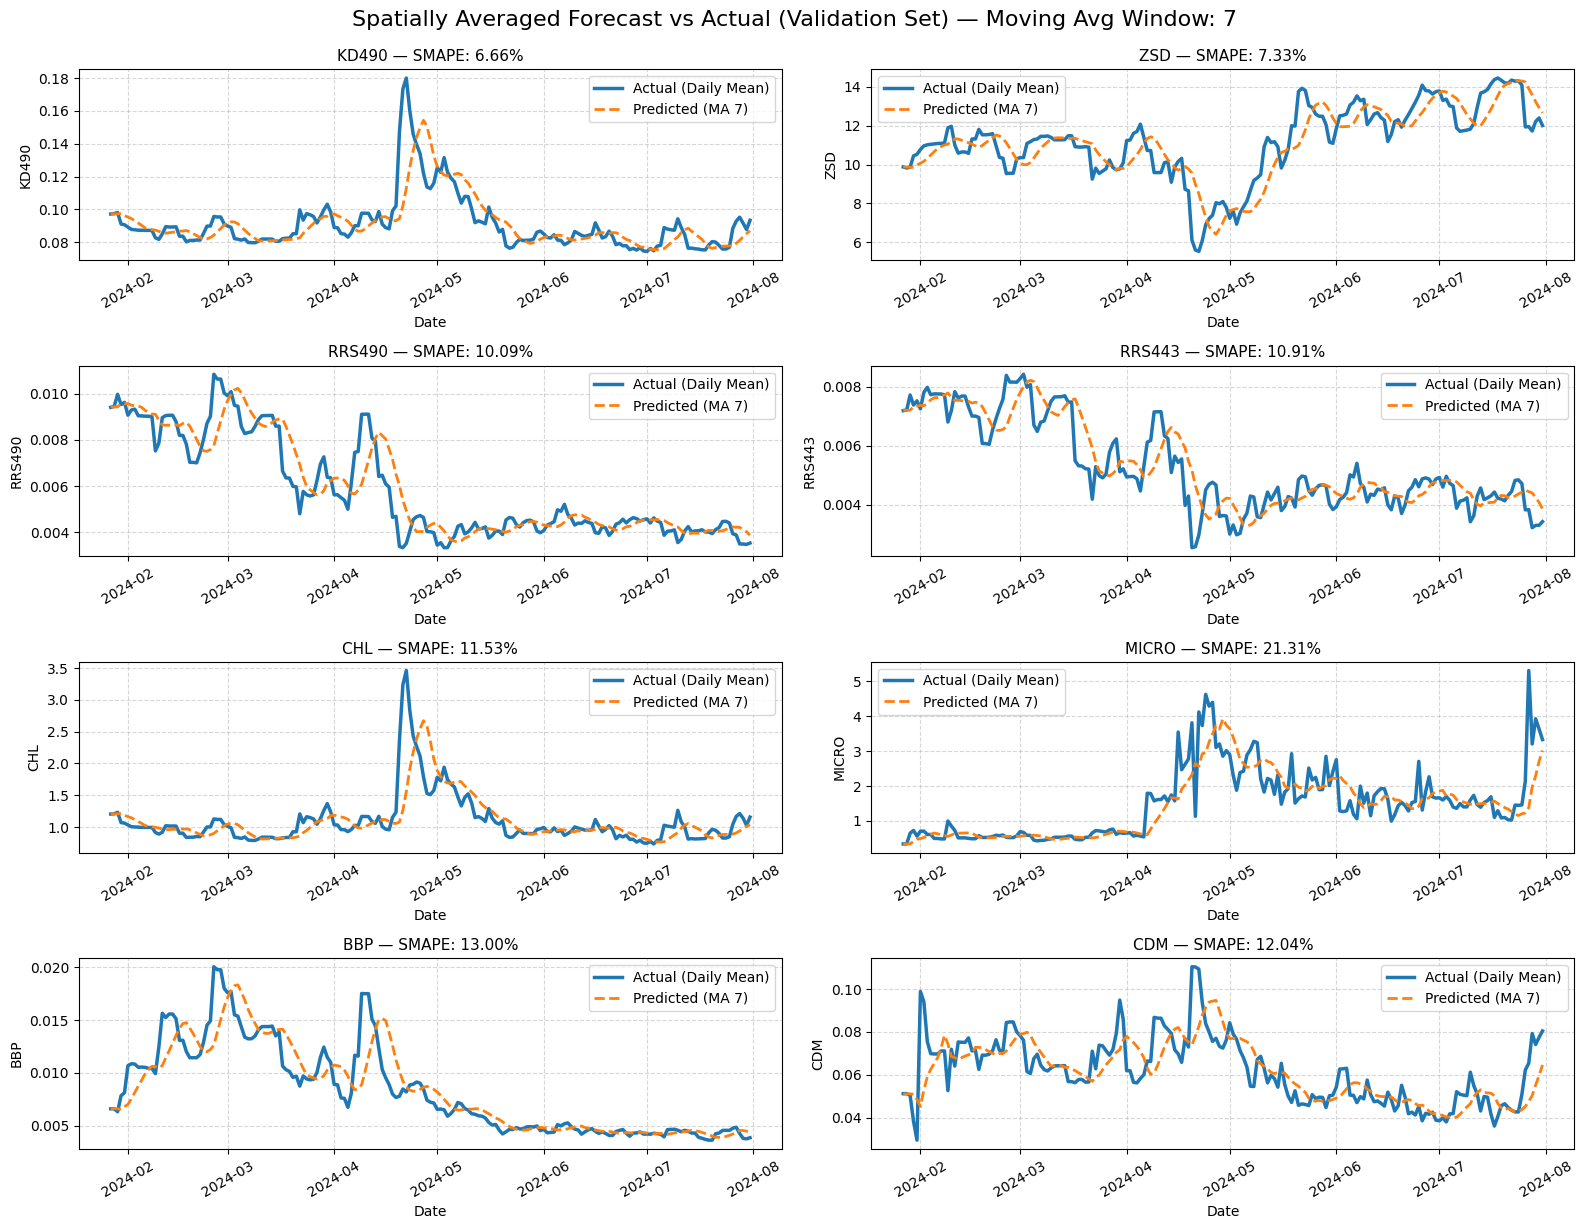

In [30]:
# Define the window for the moving average
window_size = 7

# Initialize metrics dictionary
spatial_avg_metrics = {}

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Step 1: Get validation data and average spatially
    val_df = data[data["date"].isin(val_dates)].copy()
    val_df = val_df[["date", "lat_5km", "lon_5km", var]].dropna()

    # Step 2: Compute daily spatial mean
    daily_mean = val_df.groupby("date")[var].mean()

    # Step 3: Compute rolling mean for prediction
    rolling_forecast = daily_mean.rolling(window=window_size, closed='left', min_periods=1).mean()

    # Step 4: Align and drop NaNs
    aligned_actual = daily_mean.dropna()
    aligned_pred = rolling_forecast.loc[aligned_actual.index].dropna()
    common_dates = aligned_actual.index.intersection(aligned_pred.index)
    aligned_actual = aligned_actual.loc[common_dates]
    aligned_pred = aligned_pred.loc[common_dates]

    # Store only the 3 required evaluation metrics
    smape_val = symmetric_mape(aligned_actual, aligned_pred)
    rmse_val = np.sqrt(mean_squared_error(aligned_actual, aligned_pred))
    mae_val = mean_absolute_error(aligned_actual, aligned_pred)

    spatial_avg_metrics[var] = {
        "SMAPE (%)": smape_val,
        "RMSE": rmse_val,
        "MAE": mae_val
    }

    # Step 5: Plot
    ax = axes[i]
    ax.plot(aligned_actual.index, aligned_actual.values, label="Actual (Daily Mean)", color="#1f77b4", linewidth=2.5)
    ax.plot(aligned_pred.index, aligned_pred.values, label=f"Predicted (MA {window_size})", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"{var} — SMAPE: {smape_val:.2f}%", fontsize=11)
    ax.set_xlabel("Date")
    ax.set_ylabel(var)
    ax.tick_params(axis='x', rotation=30)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

# Layout
plt.tight_layout()
plt.suptitle(f"Spatially Averaged Forecast vs Actual (Validation Set) — Moving Avg Window: {window_size}", fontsize=16, y=1.02)
plt.show()


In [31]:
# Convert results to a DataFrame
summary_df = pd.DataFrame(spatial_avg_metrics).T
print("Summary of Evaluation Metrics (Spatially Averaged Validation Data):")
print(summary_df.round(4))

Summary of Evaluation Metrics (Spatially Averaged Validation Data):
        SMAPE (%)    RMSE     MAE
KD490      6.6644  0.0114  0.0066
ZSD        7.3266  1.0081  0.7736
RRS490    10.0909  0.0009  0.0006
RRS443    10.9103  0.0007  0.0006
CHL       11.5268  0.2925  0.1474
MICRO     21.3132  0.5873  0.3592
BBP       12.9967  0.0020  0.0013
CDM       12.0352  0.0111  0.0077


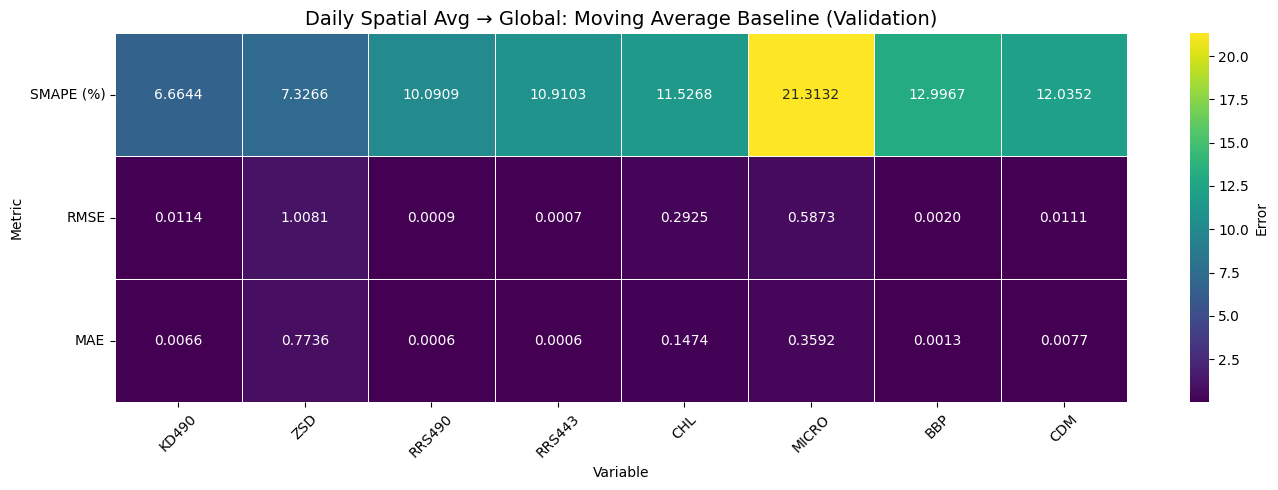

In [32]:
# Build DataFrame from spatial_avg_metrics
metrics_df_spatial = pd.DataFrame(spatial_avg_metrics).T

# Ensure column order is correct
wanted = ["SMAPE (%)", "RMSE", "MAE"]
for col in wanted:
    if col not in metrics_df_spatial.columns:
        metrics_df_spatial[col] = np.nan

# Transpose so metrics are rows, variables are columns
heatmap_data_spatial = metrics_df_spatial[wanted].T

# Plot heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(
    heatmap_data_spatial,
    annot=True, fmt=".4f",  # 4 decimal places
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Error"}
)
plt.title("Daily Spatial Avg → Global: Moving Average Baseline (Validation)", fontsize=14)
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
